# **LAB 5 - PART 1 Classification model (NN,CNN,LSTM) with Time Series Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import tensorflow as tf
from keras import Model,Input
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

import glob
from scipy import stats
import datetime as dt
from tqdm import tqdm

2024-03-08 19:59:13.865421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:59:13.865453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:59:13.866618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 19:59:13.874722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 19:59:15.072130: W tensorflow/compiler/tf2

### **Data Preparation**

**Load csv from txt files**

**- Load Acceleration**

In [3]:
# Get filename of Acceleration

### START CODE HERE ###
fnames = glob.glob("./*_acceleration.txt")
def loadGlob(fnames,names,sep):
  testers = []
  for f in tqdm(fnames):
    tester = pd.read_csv(f,names=names,sep=sep)
    testers.append(tester)
  return pd.concat(testers)

# def resample(timeDf):
#   timedelta_unit = 's' # Define the timedelta_unit variable
#   resample_rule = '1s'
#   timeDf['timedelta'] = pd.DataFrame(pd.to_timedelta(timeDf['timedelta'], timedelta_unit).round(resample_rule))
#   tempDf = timeDf.groupby('timedelta').mean().reset_index() # average of the same second
#   return tempDf.set_index('timedelta')

ACC = loadGlob(fnames[:2],['timedelta', 'accX', 'accY', 'accZ'],' ')
### END CODE HERE ###

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


In [4]:
ACC

,timedelta,accX,accY,accZ
0,-12456.814733,0.260346,-0.222687,-0.939560
1,-12456.795310,0.280960,-0.214783,-0.933167
2,-12456.774080,0.275482,-0.249451,-0.906189
3,-12456.755424,0.287628,-0.247787,-0.881287
4,-12456.735441,0.302216,-0.244110,-0.850540
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


**- Load Heart Rate**

In [5]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("./*_heartrate.txt")


HeartR = loadGlob(fnames[0:2], ["timedelta", "heartrate"], ",")

100%|██████████| 2/2 [00:00<00:00, 303.16it/s]


In [6]:
HeartR

,timedelta,heartrate
0,-556410.36066,57.0
1,-556408.36062,56.0
2,-556403.36062,56.0
3,-556399.36062,57.0
4,-556389.36062,59.0
...,...,...
4367,14222.84187,60.0
4368,14231.84187,57.0
4369,14234.84187,56.0
4370,14239.84187,57.0


In [7]:
HeartR.isna().sum()

timedelta    0
heartrate    0
dtype: int64

**- Load Labeled Sleep**

In [8]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("./*_labeled_sleep.txt")


SleepL = loadGlob(fnames[0:2], ["timedelta", "sleep"], " ")
### END CODE HERE ###

100%|██████████| 2/2 [00:00<00:00, 513.00it/s]


**- If some Sleep levels are negative (-1) -> SleepL += 1**

In [9]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
470,14100,1
471,14130,0
472,14160,1
473,14190,1


**Synchronizes 'ACC', 'HeartR', 'SleepL'** by aligning their time ranges, <br>
and then filters each dataset to only include data within the overlapping time range.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

<br> ACC start: -124489.16105       ACC end: 37458.8583889
<br> HeartR start: -604720.29398    HeartR end: 37541.70998 
<br> SleepL start: 0                SleepL end: 29400 


In [10]:
### START CODE HERE ###

#Find max, min timedelta to find intersection time 
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_data = SleepL['timedelta'].min()


MIN_DATE = max(ACC_min_date, HeartR_min_date, SleepL_min_data)
MAX_DATE = min(ACC_max_date, HeartR_max_date, SleepL_max_date)

ACC = ACC[(ACC['timedelta'] >= MIN_DATE) & (ACC['timedelta'] <= MAX_DATE)]
SleepL = SleepL[(SleepL['timedelta'] >= MIN_DATE) & (SleepL['timedelta'] <= MAX_DATE)]
HeartR = HeartR[(HeartR['timedelta'] >= MIN_DATE) & (HeartR['timedelta'] <= MAX_DATE)]


print(ACC_min_date, ACC_max_date)
print(HeartR_min_date, HeartR_max_date)
print(SleepL_min_data, SleepL_max_date)
print(MIN_DATE, MAX_DATE)
# Obtain data for ACC, HeartR, and SleepL exclusively during the intersection period.
### END CODE HERE ###

-124489.16105 37458.8583889
-573407.48573 16980.47229
0 16980
0 16980


If your code is correct, this cell will execute without any issues.

In [11]:
# print(ACC.to_numpy().shape)
# print(HeartR.to_numpy().shape)
# print(SleepL.to_numpy().shape)
# assert ACC.to_numpy().shape == (4863482, 4)
# assert HeartR.to_numpy().shape == (28655, 2)
# assert SleepL.to_numpy().shape == (2967, 2)

Converts the `'timedelta'` column of the `ACC` DataFrame to a `pandas Timedelta object` in seconds and rounds it to the nearest second.

In [12]:
## START CODE HERE ###
timedelta_unit = 's'  # Define the timedelta_unit variable
resample_rule = '1s'
ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC["timedelta"], timedelta_unit).round(resample_rule))
### END CODE HERE ###
ACC

/tmp/ipykernel_50751/906482662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC["timedelta"], timedelta_unit).round(resample_rule))


,timedelta,accX,accY,accZ
40157,0 days 00:00:00,-0.234604,0.643829,-0.713974
40158,0 days 00:00:00,-0.233948,0.622269,-0.643692
40159,0 days 00:00:00,-0.239273,0.616257,-0.657822
40160,0 days 00:00:00,-0.209808,0.640320,-0.660721
40161,0 days 00:00:00,-0.224426,0.641098,-0.685638
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


Groups the `ACC` DataFrame by `'timedelta'`, calculates the mean of `'accX', 'accY', and 'accZ'` for each group, and then concatenates these averages into a new DataFrame.

In [13]:
### START CODE HERE ###
df_acc = ACC.groupby('timedelta').mean().reset_index()
ACC = df_acc
### END CODE HERE ###
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.211796,0.833295,-0.137052
1,0 days 00:00:01,-0.304999,0.854863,0.021060
2,0 days 00:00:02,-0.368286,0.778982,0.054992
3,0 days 00:00:03,-0.288794,0.736335,-0.151884
4,0 days 00:00:04,0.236101,0.630011,-0.148900
...,...,...,...,...
16976,0 days 04:42:56,-0.500130,-0.051674,0.005909
16977,0 days 04:42:57,-0.499607,-0.051382,0.006221
16978,0 days 04:42:58,-0.499477,-0.051126,0.006785
16979,0 days 04:42:59,-0.500285,-0.046628,-0.000693


Converts the `'timedelta'` column of the `HeartR` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [14]:
### START CODE HERE ###
HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR["timedelta"],timedelta_unit).round(resample_rule))
# MEDIAN OF THE RESAMPLED GROUP
HeartR = HeartR.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
HeartR

/tmp/ipykernel_50751/2065075969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR["timedelta"],timedelta_unit).round(resample_rule))


,heartrate
timedelta,
0 days 00:00:07,75.0
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,75.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


Converts the `'timedelta'` column of the `SleepL` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [15]:
### START CODE HERE ###
resample_rule = '1s'
SleepL['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL["timedelta"],timedelta_unit).round(resample_rule))
SleepL = SleepL.drop_duplicates(subset=['timedelta'])
SleepL = SleepL.set_index('timedelta').resample(resample_rule).bfill() # Doesn't use median because it's a label (number operation result in float such as 0.5)

### END CODE HERE ###
SleepL


,sleep
timedelta,
0 days 00:00:00,-1
0 days 00:00:01,-1
0 days 00:00:02,-1
0 days 00:00:03,-1
0 days 00:00:04,-1
...,...
0 days 04:42:56,0
0 days 04:42:57,0
0 days 04:42:58,0


In [16]:
SleepL["sleep"].value_counts()

sleep
 2    5100
 3    4680
 5    3420
 0    2550
 1     870
-1     361
Name: count, dtype: int64

Merges the `ACC, HeartR, and SleepL` DataFrames into a single DataFrame df, aligning them based on their `'timedelta'` columns using an asof merge.

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	      timedelta	   accX	      accY	       accZ	  heartrate	sleep
0	0 days 00:00:00	-0.143596	0.434711	-0.558406	NaN	NaN
1	0 days 00:00:01	-0.184721	0.438487	-0.492099	NaN	NaN
2	0 days 00:00:02	-0.213871	0.403676	-0.476563	65.0	NaN
3	0 days 00:00:03	-0.176616	0.391760	-0.571252	65.0	NaN
4	0 days 00:00:04	0.072789	0.338097	-0.571049	65.0	NaN

```

In [17]:
## START CODE HERE ###
#Sort
ACC = ACC.sort_values(by='timedelta')
HeartR = HeartR.sort_values(by='timedelta')
SleepL = SleepL.sort_values(by='timedelta')
df = pd.merge_asof(ACC, HeartR, on='timedelta')
df = pd.merge_asof(df, SleepL, on = 'timedelta')
### END CODE HERE ###
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.211796,0.833295,-0.137052,NaN,-1
1,0 days 00:00:01,-0.304999,0.854863,0.021060,NaN,-1
2,0 days 00:00:02,-0.368286,0.778982,0.054992,NaN,-1
3,0 days 00:00:03,-0.288794,0.736335,-0.151884,NaN,-1
4,0 days 00:00:04,0.236101,0.630011,-0.148900,NaN,-1
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.500130,-0.051674,0.005909,76.0,0
16977,0 days 04:42:57,-0.499607,-0.051382,0.006221,76.0,0
16978,0 days 04:42:58,-0.499477,-0.051126,0.006785,76.0,0
16979,0 days 04:42:59,-0.500285,-0.046628,-0.000693,76.0,0


Fills missing values in the `'heartrate'` column with the column's median,<br> 
Fills missing values in the `'sleep'` column with 0,<br> 
and then drops the `'timedelta'` column from the df DataFrame.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	   accX	      accY	      accZ	heartrate	sleep
0	-0.143596	0.434711	-0.558406	62.0	0.0
1	-0.184721	0.438487	-0.492099	62.0	0.0
2	-0.213871	0.403676	-0.476563	65.0	0.0
3	-0.176616	0.391760	-0.571252	65.0	0.0
4	0.072789	0.338097	-0.571049	65.0	0.0
```

In [18]:
### START CODE HERE ###
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df['sleep'] = df['sleep'].fillna(0)
df.drop(["timedelta"], axis=1, inplace=True)
### END CODE HERE ###
df

,accX,accY,accZ,heartrate,sleep
0,-0.211796,0.833295,-0.137052,74.5,-1
1,-0.304999,0.854863,0.021060,74.5,-1
2,-0.368286,0.778982,0.054992,74.5,-1
3,-0.288794,0.736335,-0.151884,74.5,-1
4,0.236101,0.630011,-0.148900,74.5,-1
...,...,...,...,...,...
16976,-0.500130,-0.051674,0.005909,76.0,0
16977,-0.499607,-0.051382,0.006221,76.0,0
16978,-0.499477,-0.051126,0.006785,76.0,0
16979,-0.500285,-0.046628,-0.000693,76.0,0


In [19]:
df.isna().sum()

accX         0
accY         0
accZ         0
heartrate    0
sleep        0
dtype: int64

1. Separate X input[['accX', 'accY', 'accZ', 'heartrate'] ]and Y output[['sleep']]
2. Perform data scaling using Standardize,<br>
3. Perform SMA: Simple Moving Average to reduce noise in signals ,<br>

In [20]:
### START CODE HERE ###
feature_columns = ["accX", "accY", "accZ", "heartrate"]
label_columns = ["sleep"]

df_feature = df[feature_columns]
df_label = df[label_columns]

scaler = StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature), columns=feature_columns)

df_feature_SMA = pd.DataFrame()
wsize = 10
minp = 1
df_feature_SMA['accX'] = df_feature['accX'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(wsize, min_periods=minp).mean()
### END CODE HERE ###

Graph of all signals before and after Standardize and SMA
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

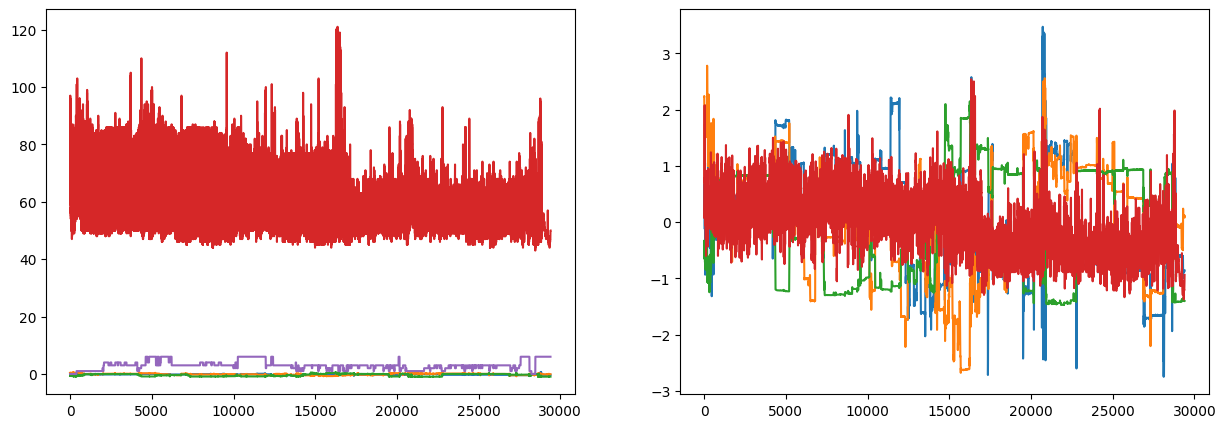

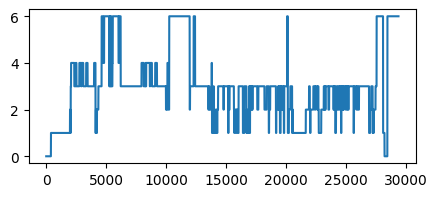

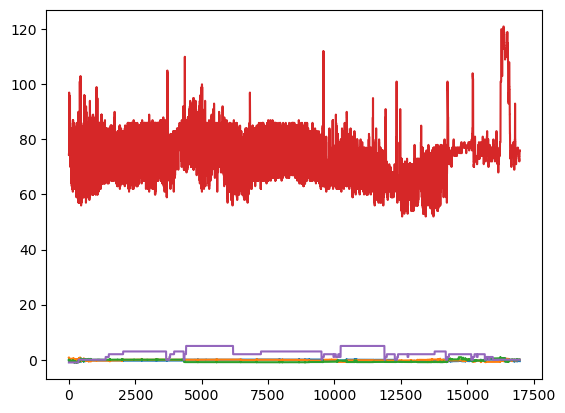

In [21]:
plt.plot(df)                
plt.show()

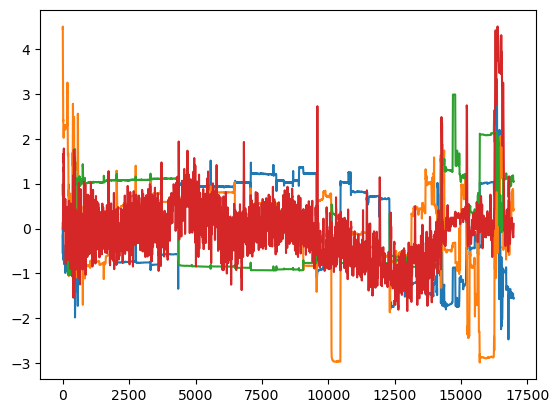

In [22]:
### START CODE HERE ###
# Before Standardize and SMA
# After
plt.plot(df_feature_SMA)
plt.show()
### END CODE HERE ###

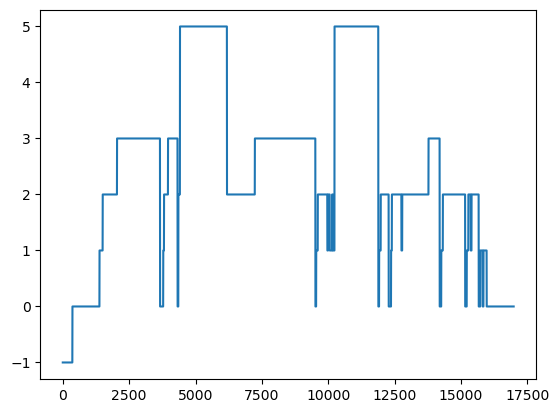

In [23]:
# Graph Sleep labels
plt.plot(df_label)

### **Model Experimentaion**

**Train Test Data Preparation**

In [24]:
X = df_feature_SMA
y = df_label

In [25]:
random_state = 42

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=random_state)

##### **Neural Network**
**Create MLP (NN) Model Architecture**

In [27]:
hiddenL = (50, 50, 50)
act = 'relu'
EP = 10000
lr = 0.01
optimizer = 'adam'
SEED_init = None
tolr = 0.0
mlp = MLPClassifier(hidden_layer_sizes=hiddenL,activation=act ,max_iter=EP, alpha=lr,solver=optimizer, random_state=random_state,tol=tolr)
mlp

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50, 50), max_iter=10000,
              random_state=42, tol=0.0)

**Traning MLP (NN) Model**

In [28]:
x_train

,accX,accY,accZ,heartrate
16064,1.021474,-2.865443,2.086246,0.191668
11934,0.503575,-0.503824,-0.664835,0.735438
6366,0.925699,0.809284,-0.847878,-0.575437
2527,-0.730793,0.515408,1.073995,0.332465
14317,-1.297757,1.637791,1.443325,0.113986
...,...,...,...,...
11284,0.819283,-0.086031,-0.832214,-0.653118
11964,0.649383,-0.654753,-0.751581,-0.546306
5390,0.937997,0.641083,-0.847657,0.201378
860,-0.380722,-0.831801,1.011807,-1.031816


In [29]:
mlp.fit(x_train, y_train)

/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50, 50), max_iter=10000,
              random_state=42, tol=0.0)

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       192
           1       0.86      0.73      0.79      1246
           2       0.77      0.35      0.48      1224
           3       0.84      0.82      0.83      4153
           4       0.64      0.75      0.69       603
           5       0.88      0.88      0.88      1403

   micro avg       0.83      0.74      0.78      8821
   macro avg       0.80      0.71      0.74      8821
weighted avg       0.82      0.74      0.77      8821
 samples avg       0.73      0.74      0.73      8821
```
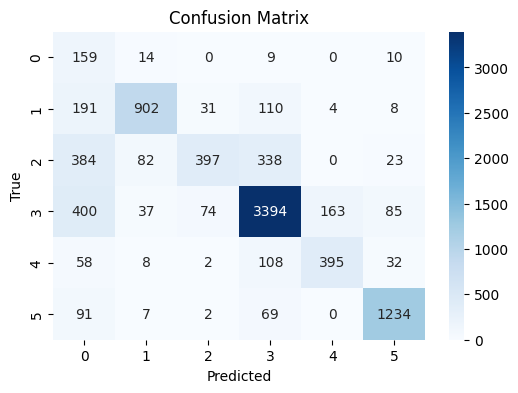

**MLP (NN) Model Prediction**

In [30]:
y_pred = mlp.predict(x_test)

**MLP (NN) Model Performance (Confusion Matrix, Classification_report)**


In [31]:
print('----- Classification Report of MLP NN predict X_test -----')
print(classification_report(y_test, y_pred))
print('----- Confusion matrix of MLP NN predict X_test -----')
print(confusion_matrix(y_test, y_pred))

----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

          -1       0.95      0.98      0.97       116
           0       0.83      0.84      0.84       740
           1       0.61      0.54      0.57       245
           2       0.92      0.86      0.89      1522
           3       0.93      0.96      0.95      1460
           5       0.91      0.97      0.94      1012

    accuracy                           0.90      5095
   macro avg       0.86      0.86      0.86      5095
weighted avg       0.90      0.90      0.90      5095

----- Confusion matrix of MLP NN predict X_test -----
[[ 114    2    0    0    0    0]
 [   5  625   44   20   38    8]
 [   0   73  132   33    4    3]
 [   1   50   27 1310   55   79]
 [   0    6    2   43 1407    2]
 [   0    1   13   11    5  982]]


##### **Train-Test Data Preparation for CNN Training**
1. Non-Transpose Data (XR Shape1: sliding window size, n_feature)
2. Transpose Data  (XT Shape2: n_feature, sliding window size)

**Non-Transpose data (XR)**



In [32]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, 

X = df_feature_SMA
Y = df_label
XR = [ ]

y = []
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])        
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)  
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote : mode of labels for whole array 
    mode_values, countL = stats.mode(label,axis=None) 
    label = mode_values
    
    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yR = y

**Non-Transpose Tran_test_split data**

In [33]:
#----- CNN with XR -----------
#--- Train - Validate - Test ----
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state=random_state)

In [34]:
yR.shape

(1689, 6)

##### **CNN Architecture (XR)**

In [35]:
CNN_L1 = 32
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yR.shape[1]
learning_rate = 0.01

pDrop = 0.4

Input_shape = (slidingW, n_feature, 1)
P_size = (2,1)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, padding='same', activation=Act_func, input_shape=Input_shape))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = optimizers.Adam(learning_rate)
model.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 4, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 4, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 4, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 4, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 4, 128)        0

##### **Train CNN(XR)**

In [36]:
historyXR = model.fit(XR_train, yR_train, epochs=100, validation_data=(XR_test, yR_test))

Epoch 1/100


37/37 [==============================] - 4s 76ms/step - loss: 2.0144 - acc: 0.2157 - val_loss: 1.5469 - val_acc: 0.2919
Epoch 2/100
37/37 [==============================] - 3s 72ms/step - loss: 1.5641 - acc: 0.3080 - val_loss: 1.5054 - val_acc: 0.3037
Epoch 3/100
37/37 [==============================] - 3s 69ms/step - loss: 1.5614 - acc: 0.3113 - val_loss: 1.5080 - val_acc: 0.3037
Epoch 4/100
37/37 [==============================] - 3s 76ms/step - loss: 1.5643 - acc: 0.3113 - val_loss: 1.5108 - val_acc: 0.3037
Epoch 5/100
37/37 [==============================] - 3s 71ms/step - loss: 1.5659 - acc: 0.3113 - val_loss: 1.5062 - val_acc: 0.3037
Epoch 6/100
37/37 [==============================] - 3s 71ms/step - loss: 1.5610 - acc: 0.2995 - val_loss: 1.5097 - val_acc: 0.3037
Epoch 7/100
37/37 [==============================] - 3s 74ms/step - loss: 1.5646 - acc: 0.2995 - val_loss: 1.5076 - val_acc: 0.3037
Epoch 8/100
37/37 [==============================] - 3s 72ms/step - loss: 1.5651 - acc: 

##### **CNN (XR) Performance**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

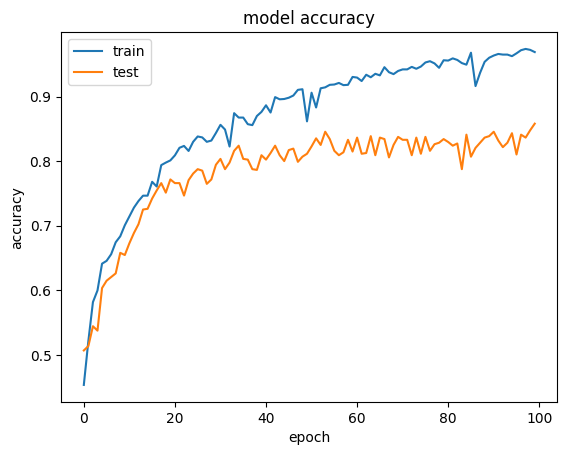
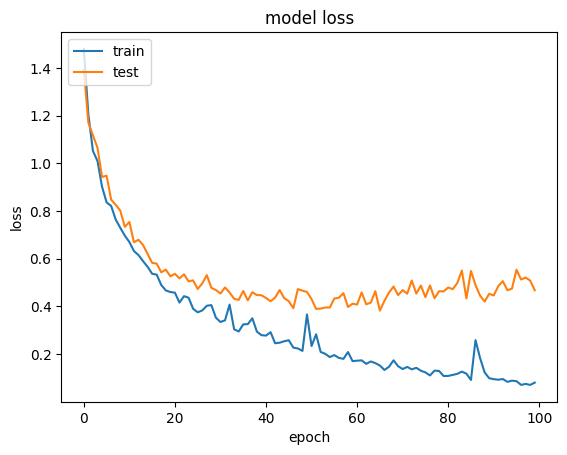

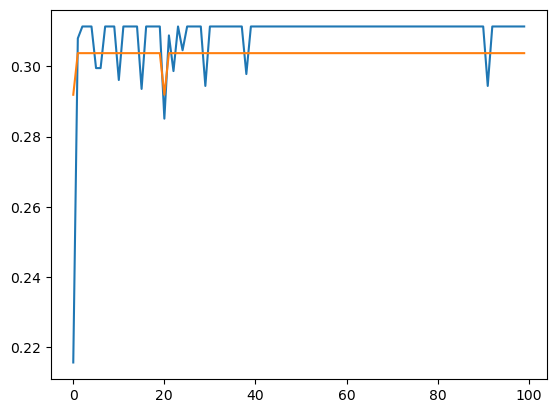

In [37]:
# summarize history for accuracy
def plotHistAcc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plotHistAcc(historyXR)

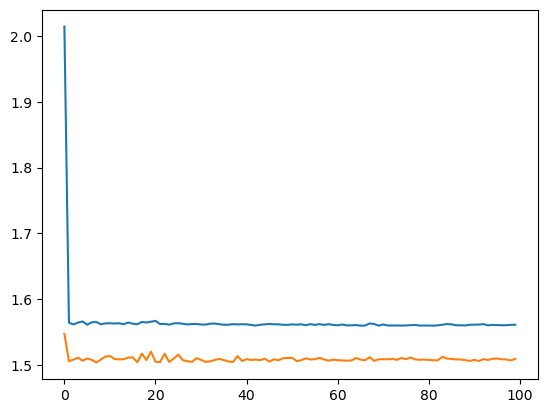

In [38]:
# summarize history for loss
def plotHistLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
plotHistLoss(historyXR)

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

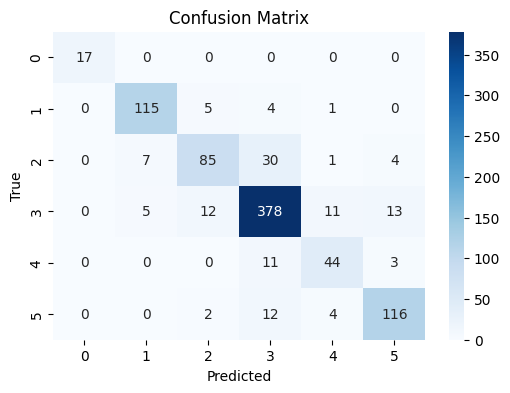

```
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.92      0.91       125
           2       0.82      0.67      0.74       127
           3       0.87      0.90      0.89       419
           4       0.72      0.76      0.74        58
           5       0.85      0.87      0.86       134

    accuracy                           0.86       880
   macro avg       0.86      0.85      0.86       880
weighted avg       0.86      0.86      0.86       880
```

In [39]:
def predictAndReport(model,X_test,Y_test):
    CNN_pred = model.predict(X_test)
    # Convert  nn output to label
    y_pred = np.argmax(CNN_pred, axis=1)
    y_true = np.argmax(np.array(Y_test), axis=1)

    print('----- Classification Report of CNN predict X_test -----')

    print(classification_report(y_true, y_pred))
    print('----- Confusion matrix of CNN predict X_test -----')
    print(confusion_matrix(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

16/16 [==============================] - 0s 8ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        19
           3       0.30      1.00      0.47       154
           4       0.00      0.00      0.00       148
           5       0.00      0.00      0.00       104

    accuracy                           0.30       507
   macro avg       0.05      0.17      0.08       507
weighted avg       0.09      0.30      0.14       507

----- Confusion matrix of CNN predict X_test -----
[[  0   0   0   4   0   0]
 [  0   0   0  78   0   0]
 [  0   0   0  19   0   0]
 [  0   0   0 154   0   0]
 [  0   0   0 148   0   0]
 [  0   0   0 104   0   0]]


/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


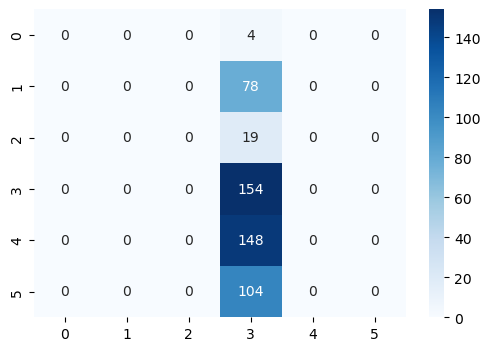

In [40]:
predictAndReport(model,XR_test,yR_test)

### **Transpose data (XT)**

In [41]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = np.array(X.iloc[i: i+slidingW])        
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW, 1)
    # label sliding windows = df_label[i:i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(label,axis=None) 

    label = mode_values
    
    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yT = y

##### **Train Test Split (XT)**

In [42]:
#----- CNN with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=random_state)

##### **CNN Architecture (XT)**

In [43]:
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yT.shape[1]
print(Nclass)

Input_shape = (n_feature, slidingW, 1)
P_size = (1,2)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, padding='same', activation=Act_func, input_shape=Input_shape))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = optimizers.Adam(learning_rate)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy, metrics=["acc"])
model.summary()

6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 4, 100, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 50, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 50, 64)         9280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 25, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 25, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 12, 128)     

##### **Train CNN (XT)**

In [44]:
historyXT = model.fit(XT_train, yT_train, epochs=100, validation_data=(XT_test, yT_test))

Epoch 1/100
37/37 [==============================] - 3s 55ms/step - loss: 1.6907 - acc: 0.4289 - val_loss: 0.9656 - val_acc: 0.6174
Epoch 2/100
37/37 [==============================] - 2s 53ms/step - loss: 0.9168 - acc: 0.6379 - val_loss: 0.7484 - val_acc: 0.7061
Epoch 3/100
37/37 [==============================] - 2s 60ms/step - loss: 0.7819 - acc: 0.6844 - val_loss: 0.6339 - val_acc: 0.7416
Epoch 4/100
37/37 [==============================] - 2s 65ms/step - loss: 0.7182 - acc: 0.7191 - val_loss: 0.6948 - val_acc: 0.7515
Epoch 5/100
37/37 [==============================] - 3s 83ms/step - loss: 0.6619 - acc: 0.7293 - val_loss: 0.6183 - val_acc: 0.7633
Epoch 6/100
37/37 [==============================] - 2s 58ms/step - loss: 0.6398 - acc: 0.7386 - val_loss: 0.5818 - val_acc: 0.7594
Epoch 7/100
37/37 [==============================] - 2s 60ms/step - loss: 0.5809 - acc: 0.7572 - val_loss: 0.4615 - val_acc: 0.8107
Epoch 8/100
37/37 [==============================] - 2s 60ms/step - loss: 0.

37/37 [==============================] - 3s 69ms/step - loss: 0.4942 - acc: 0.7910 - val_loss: 0.5644 - val_acc: 0.7850
Epoch 11/100
37/37 [==============================] - 3s 75ms/step - loss: 0.5391 - acc: 0.7851 - val_loss: 0.4840 - val_acc: 0.8067
Epoch 12/100
37/37 [==============================] - 3s 71ms/step - loss: 0.4541 - acc: 0.8232 - val_loss: 0.6914 - val_acc: 0.7751
Epoch 13/100
37/37 [==============================] - 3s 71ms/step - loss: 0.4672 - acc: 0.8232 - val_loss: 0.6947 - val_acc: 0.7554
Epoch 14/100
37/37 [==============================] - 3s 68ms/step - loss: 0.5465 - acc: 0.8173 - val_loss: 0.4821 - val_acc: 0.8245
Epoch 15/100
37/37 [==============================] - 2s 67ms/step - loss: 0.5348 - acc: 0.8130 - val_loss: 0.5994 - val_acc: 0.7613
Epoch 16/100
37/37 [==============================] - 3s 89ms/step - loss: 0.4641 - acc: 0.8190 - val_loss: 0.4688 - val_acc: 0.8501
Epoch 17/100
37/37 [==============================] - 4s 116ms/step - loss: 0.4377

##### **CNN Performance (XT)**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

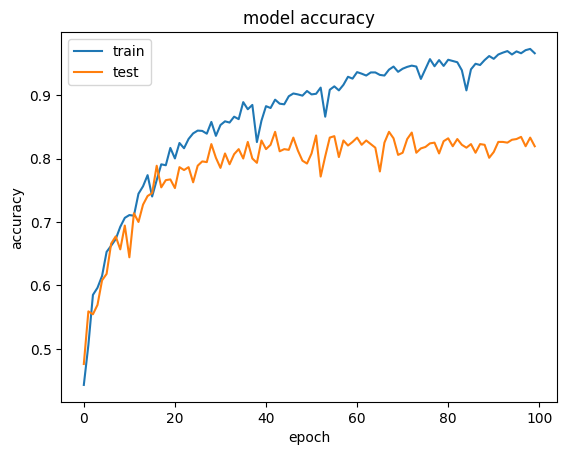
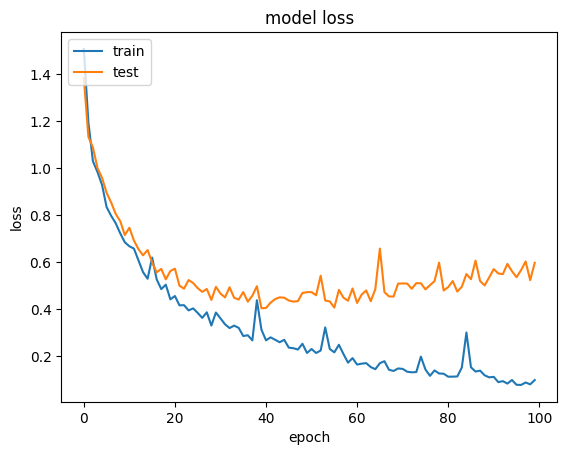

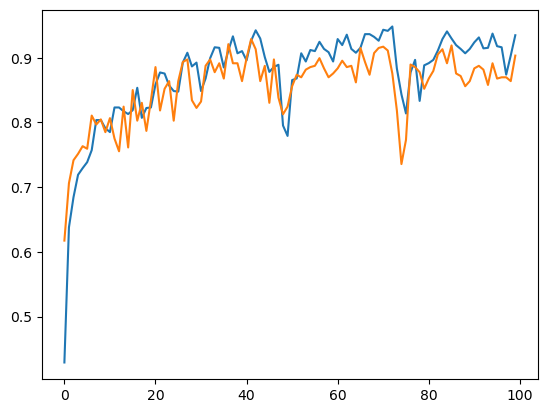

In [45]:
# summarize history for accuracy
plotHistAcc(historyXT)

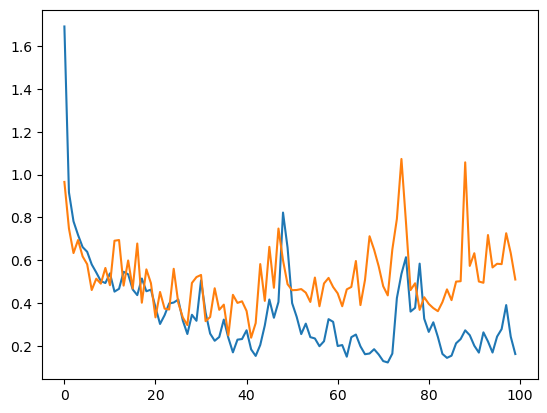

In [46]:
# summarize history for loss
plotHistLoss(historyXT)

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

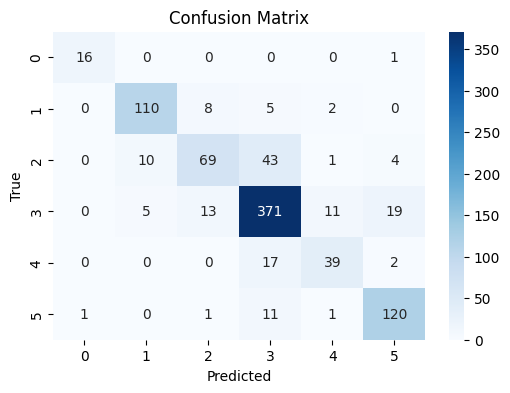

```
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.88      0.88      0.88       125
           2       0.76      0.54      0.63       127
           3       0.83      0.89      0.86       419
           4       0.72      0.67      0.70        58
           5       0.82      0.90      0.86       134

    accuracy                           0.82       880
   macro avg       0.83      0.80      0.81       880
weighted avg       0.82      0.82      0.82       880
```

16/16 [==============================] - 0s 12ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.81      0.90      0.85        78
           2       0.71      0.26      0.38        19
           3       0.93      0.88      0.91       154
           4       0.88      0.97      0.92       148
           5       0.99      0.96      0.98       104

    accuracy                           0.90       507
   macro avg       0.86      0.83      0.82       507
weighted avg       0.90      0.90      0.90       507

----- Confusion matrix of CNN predict X_test -----
[[  4   0   0   0   0   0]
 [  1  70   0   1   6   0]
 [  0  10   5   2   1   1]
 [  0   5   1 136  12   0]
 [  0   1   0   4 143   0]
 [  0   0   1   3   0 100]]


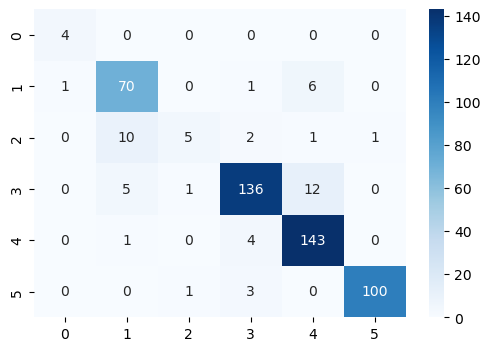

In [47]:
predictAndReport(model,XT_test,yT_test)

### **Long Short Term Memory (LSTM)**

**Train-Test Data Preparation**
LSTM Use data XR, XT same as CNN

##### **LSTM (XR) Model Architecture**

In [48]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 350, 500]
n_hidden1 = Nodes[1]
n_hidden2 = Nodes[4]

Nclass = yR.shape[1]
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Input_shape = (slidingW, n_feature)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1))

model.add(LSTM(n_hidden2))
model.add(Dropout(dropRate_L2))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          42000     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250)               351000    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1506      
                                                                 
Total params: 394506 (1.50 MB)
Trainable params: 394506 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [49]:
# Compiling the model
adam = optimizers.Adam(learning_rate=0.010)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

##### **Training LSTM (XR) Model**

In [50]:
# Training the model
EP = 100
batch_size = None

historyL_XR = model.fit(XR_train, yR_train, epochs=EP, batch_size=batch_size, validation_data=(XR_test, yR_test))

Epoch 1/100


37/37 [==============================] - 18s 383ms/step - loss: 1.3351 - acc: 0.4552 - val_loss: 1.0744 - val_acc: 0.5700
Epoch 2/100
37/37 [==============================] - 12s 329ms/step - loss: 1.2961 - acc: 0.4543 - val_loss: 1.4614 - val_acc: 0.3037
Epoch 3/100
37/37 [==============================] - 10s 281ms/step - loss: 1.5042 - acc: 0.4095 - val_loss: 1.3102 - val_acc: 0.4162
Epoch 4/100
37/37 [==============================] - 10s 272ms/step - loss: 1.5995 - acc: 0.3460 - val_loss: 1.4253 - val_acc: 0.3787
Epoch 5/100
37/37 [==============================] - 10s 281ms/step - loss: 1.5103 - acc: 0.3832 - val_loss: 1.2471 - val_acc: 0.4063
Epoch 6/100
37/37 [==============================] - 10s 265ms/step - loss: 1.4160 - acc: 0.3875 - val_loss: 1.2235 - val_acc: 0.4517
Epoch 7/100
37/37 [==============================] - 10s 267ms/step - loss: 1.3402 - acc: 0.4137 - val_loss: 1.1504 - val_acc: 0.4675
Epoch 8/100
37/37 [==============================] - 11s 287ms/step - loss

 **LSTM (XR) Model Performance**

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

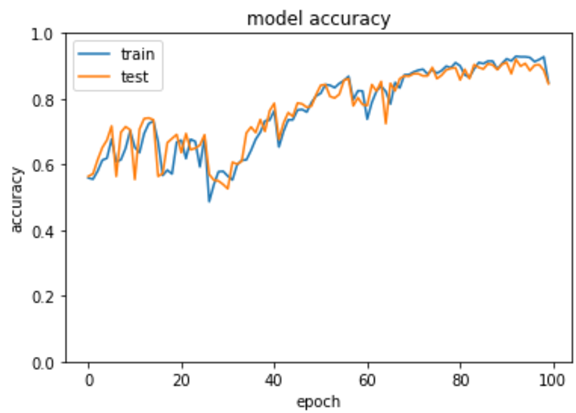

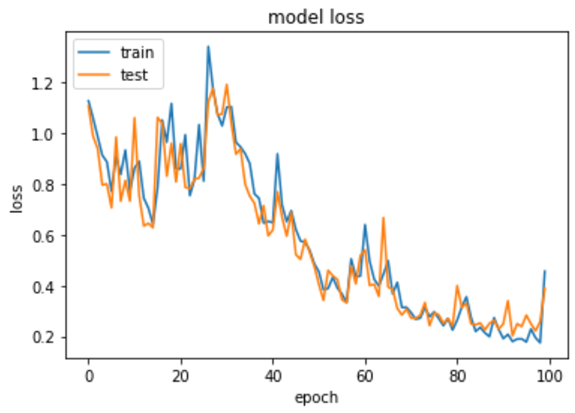

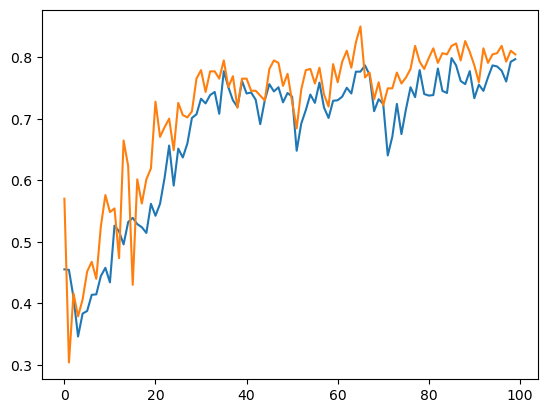

In [51]:
# summarize history for accuracy
plotHistAcc(historyL_XR)

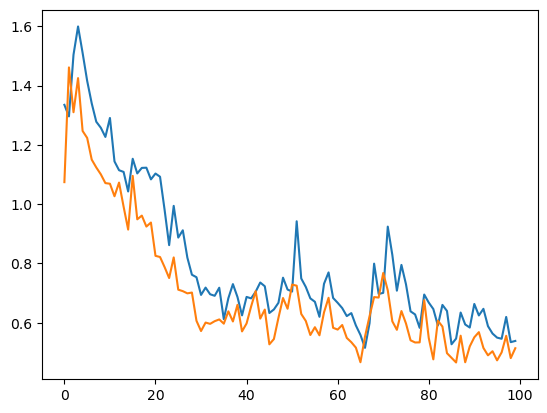

In [52]:
# summarize history for loss
plotHistLoss( historyL_XR)


**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

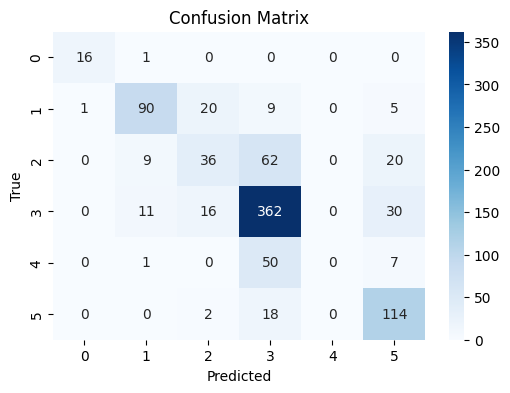

```
             precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.80      0.72      0.76       125
           2       0.49      0.28      0.36       127
           3       0.72      0.86      0.79       419
           4       0.00      0.00      0.00        58
           5       0.65      0.85      0.74       134

    accuracy                           0.70       880
   macro avg       0.60      0.61      0.60       880
weighted avg       0.65      0.70      0.66       880

```

16/16 [==============================] - 2s 76ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.77      0.51      0.62        78
           2       0.75      0.32      0.44        19
           3       0.77      0.79      0.78       154
           4       0.87      0.93      0.90       148
           5       0.78      0.95      0.86       104

    accuracy                           0.80       507
   macro avg       0.82      0.71      0.74       507
weighted avg       0.80      0.80      0.79       507

----- Confusion matrix of CNN predict X_test -----
[[  3   0   0   0   0   1]
 [  0  40   2  29   7   0]
 [  0   7   6   2   1   3]
 [  0   5   0 122  11  16]
 [  0   0   0   2 138   8]
 [  0   0   0   3   2  99]]


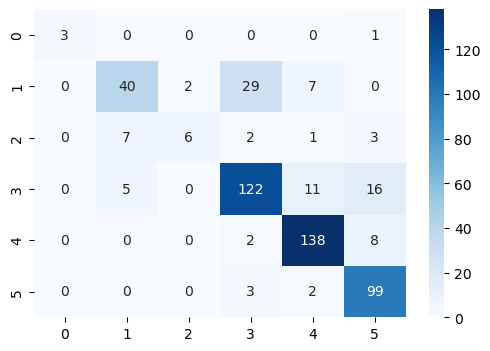

In [53]:
predictAndReport(model,XR_test,yR_test)

##### **Prepare (XT) Data**

##### **Create LSTM (XT) Model Architecture**

In [54]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 350, 500]
n_hidden1 = Nodes[1]
n_hidden2 = Nodes[4]

Nclass = yR.shape[1]
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Input_shape = (n_feature, slidingW)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1))

model.add(LSTM(n_hidden2))
model.add(Dropout(dropRate_L2))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 250)               351000    
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1506      
                                                                 
Total params: 432906 (1.65 MB)
Trainable params: 432906 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [56]:
# Compiling the model
adam = optimizers.Adam(learning_rate=0.010)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [57]:
# Training the model
EP = 100
batch_size = None

historyL_XT = model.fit(XT_train, yT_train, epochs=EP, batch_size=batch_size, validation_data=(XT_test, yT_test))

Epoch 1/100


37/37 [==============================] - 5s 43ms/step - loss: 1.3024 - acc: 0.4822 - val_loss: 0.9679 - val_acc: 0.6095
Epoch 2/100
37/37 [==============================] - 1s 21ms/step - loss: 0.8626 - acc: 0.6565 - val_loss: 0.6320 - val_acc: 0.7653
Epoch 3/100
37/37 [==============================] - 1s 21ms/step - loss: 0.6972 - acc: 0.7124 - val_loss: 0.5563 - val_acc: 0.7791
Epoch 4/100
37/37 [==============================] - 1s 22ms/step - loss: 0.5586 - acc: 0.7783 - val_loss: 0.5719 - val_acc: 0.7988
Epoch 5/100
37/37 [==============================] - 1s 19ms/step - loss: 0.5080 - acc: 0.8071 - val_loss: 0.4237 - val_acc: 0.8540
Epoch 6/100
37/37 [==============================] - 1s 20ms/step - loss: 0.4821 - acc: 0.8190 - val_loss: 0.4228 - val_acc: 0.8343
Epoch 7/100
37/37 [==============================] - 1s 22ms/step - loss: 0.4185 - acc: 0.8409 - val_loss: 0.4932 - val_acc: 0.8225
Epoch 8/100
37/37 [==============================] - 1s 23ms/step - loss: 0.4877 - acc: 

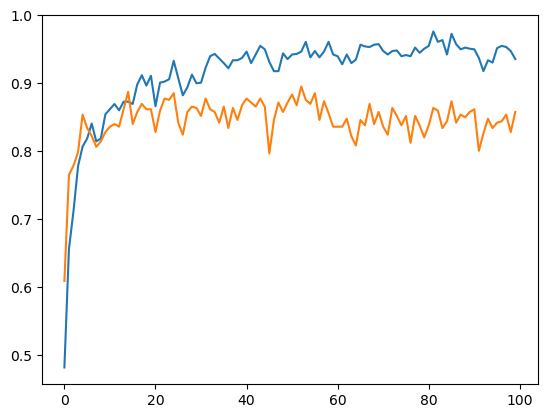

In [58]:
# summarize history for accuracy
plotHistAcc(historyL_XT)

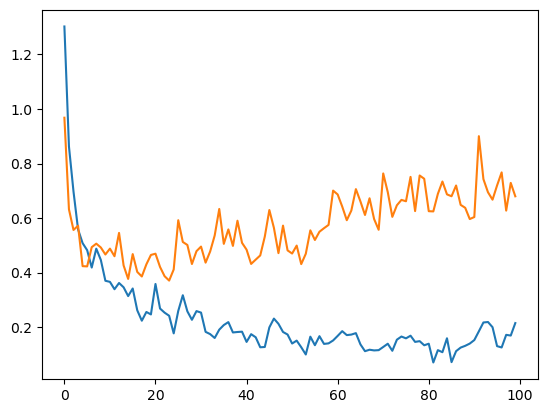

In [59]:
plotHistLoss(historyL_XT)
# Should stop at cross road
# will add callbacks @ .fit

16/16 [==============================] - 1s 5ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.79      0.83      0.81        78
           2       0.75      0.47      0.58        19
           3       0.87      0.83      0.85       154
           4       0.84      0.92      0.88       148
           5       0.94      0.89      0.92       104

    accuracy                           0.86       507
   macro avg       0.83      0.83      0.82       507
weighted avg       0.86      0.86      0.86       507

----- Confusion matrix of CNN predict X_test -----
[[  4   0   0   0   0   0]
 [  0  65   1   4   8   0]
 [  0   7   9   0   1   2]
 [  1   8   2 128  12   3]
 [  0   2   0   9 136   1]
 [  0   0   0   6   5  93]]


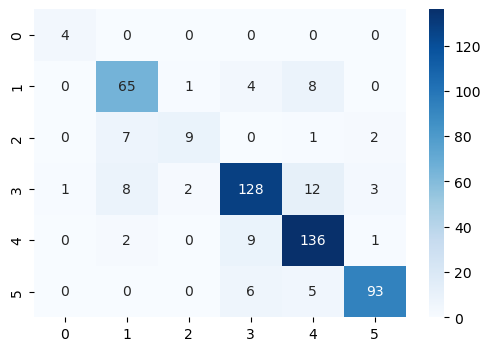

In [60]:
predictAndReport(model,XT_test,yT_test)